In [37]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    KFold, 
    cross_val_score, 
    StratifiedKFold,
    train_test_split,
    RandomizedSearchCV
)

from sklearn.linear_model import (
    LinearRegression, 
    Lasso, 
    Ridge
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

In [38]:
# get parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# path file to load
file_to_load = os.path.join(parent_dir, "datasets/preprocessed/")

# path file to save
file_to_save = os.path.join(parent_dir, "assets/")

# Data Understanding.

In [39]:
# file path
filename = "data_daegu_apartment.csv"
file_path = os.path.join(file_to_load, filename)

df = pd.read_csv(file_path)

In [40]:
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [41]:
# shape
df.shape

(4123, 11)

In [42]:
# informasi dasar mengenai dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HallwayType                       4123 non-null   object 
 1   TimeToSubway                      4123 non-null   object 
 2   SubwayStation                     4123 non-null   object 
 3   N_FacilitiesNearBy(ETC)           4123 non-null   float64
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   float64
 5   N_SchoolNearBy(University)        4123 non-null   float64
 6   N_Parkinglot(Basement)            4123 non-null   float64
 7   YearBuilt                         4123 non-null   int64  
 8   N_FacilitiesInApt                 4123 non-null   int64  
 9   Size(sqf)                         4123 non-null   int64  
 10  SalePrice                         4123 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 354.4+ KB


## Feature Information

* **HallwayType** : Tipe ruang masuk apartement.
* **TimeToSubway** : Waktu yang diperlukan dari apartement ke stasiun kereta bawah tanah (kategorikal).
* **SubwayStation** : Nama stasiun bawah tanah didekat apartement.
* **N_FacilitiesNearBy(ETC)** : Jumlah fasilitas publik didekat apartement seperti hotel dan sekolah khusus.
* **N_FacilitiesNearBy(PublicOffice)** : Jumlah public offices didekat apartement.
* **N_SchoolNearBy(University)** : Jumlah universitas didekat apartement.
* **N_Parkinglot(Basement)** : Jumlah tempat parkir di basement.
* **YearBuilt** : Tahun dibangun.
* **N_FacilitiesInApt** : Jumlah fasilitas untuk penghuni, seperti kolam renang, _gym_, dan _playground_
* **Size(sqf)** : ukuran apartement dalam _square feet_
* **SalePrice** : Harga dalam US$ (target)

## Check Duplicate

In [43]:
# memeriksa baris duplikat pada data dan menghapusnya
# data duplikat hanya menambah informasi yang tidak diperlukan.
print("Jumlah data duplikasi : ", df.duplicated(keep = "first").sum())

# menghapus baris data yang duplikat
df.drop_duplicates(keep = "first", inplace = True)

Jumlah data duplikasi :  1422


## Check Descriptive Statistics

In [44]:
# Kolom numerik
display(df.describe())

# kolom kategori
display(df.describe(include = "O"))

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,1.890411,4.027027,2.680489,533.746390,2002.358386,5.713439,984.028878,229511.365790
std,2.153168,1.887486,1.504470,418.224859,9.151949,2.386552,391.982619,105079.891321
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,181.000000,1993.000000,4.000000,743.000000,153539.000000
50%,1.000000,4.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,221238.000000
75%,5.000000,5.000000,4.000000,798.000000,2007.000000,7.000000,1167.000000,300884.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


,HallwayType,TimeToSubway,SubwayStation
count,2701,2701,2701
unique,3,5,8
top,terraced,0-5min,Myung-duk
freq,1667,1248,709


Dari deskripsi diatas, kita akan melakukan encoding pada data kategorikal sesuai dengan jumlah unique valuenya. Jika unique value nya lebih dari 5 maka kita akan terapkan binary encoder, dan one hot encoder jika sebaliknya. Kita juga akan menaruh perhatian khusus pada kolom `YearBuilt` (tahun bangunan dibuat), karena walaupun tahun merupakan data numerik tetapi angkanya tidak dapat dioperasikan secara matematis karena akan susah diinterpretasikan.

Terlihat bahwa kolom target memiliki nilai yang besar, dari puluhan ribu sampai ratusan ribu. Menggunakan MSE sebagai evaluation metrics akan membuat error cenderung besar karena residual atau jarak antara nilai real dan prediksi nantinya akan lumayan besar juga. Sehingga pilihan kita salah satunya adalah dengan menggunakan RMSE atau MAE. Jika nilai outlier ada banyak pada kolom target, maka MAE cocok untuk digunakan. Namun jika tidak banyak dan distribusinya kelihatan normal, maka RMSE tepat untuk digunakan. Dalam notebook ini RMSE akan dijadikan sebagai acuan sebagai evaluation metrics nya.

# Exploratory Data Analysis

In [45]:
# split numerical and categorical

num_vars = [col for col in df.columns if df[col].dtypes != "O"]
cat_vars = [col for col in df.columns if df[col].dtypes == "O"]

## Univariate

### Numercial Category

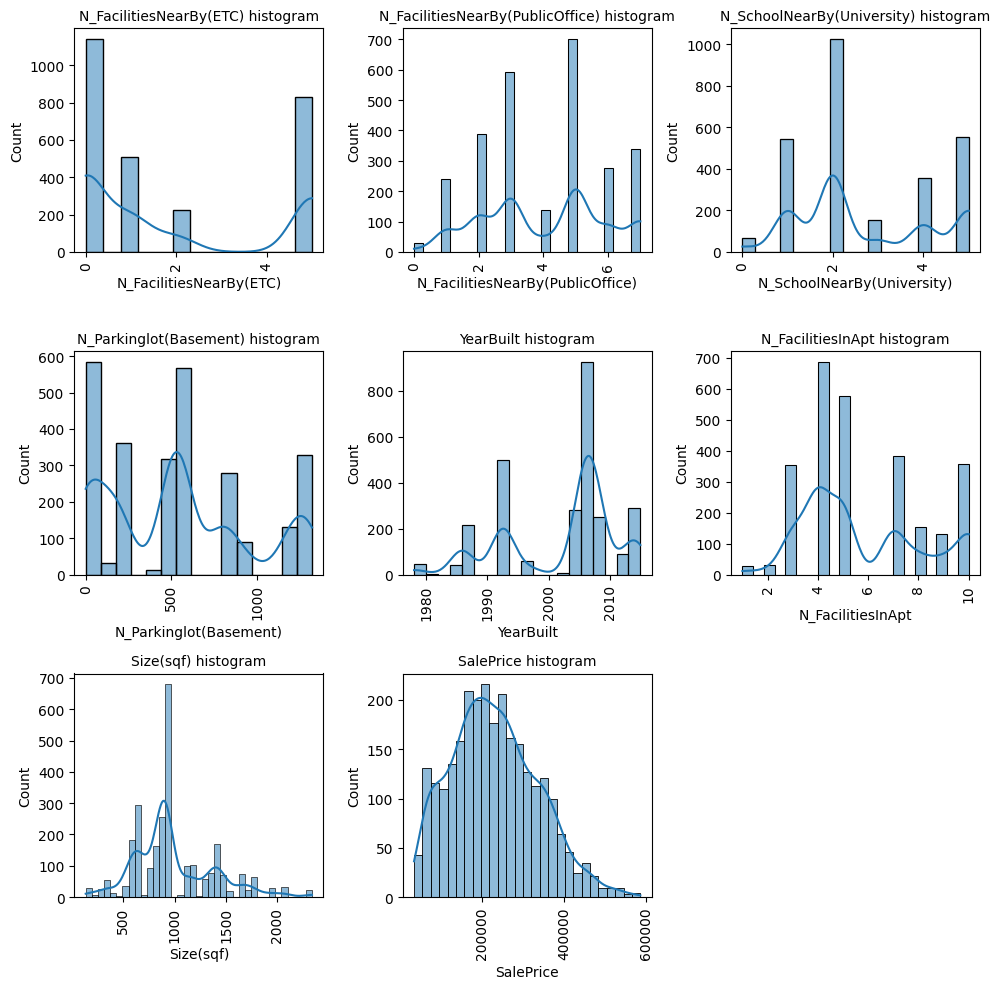

In [57]:
plt.figure(figsize=(10, 10))
for i, var in enumerate(num_vars):
    plt.subplot(3, 3, i+1)
    plt.title(f"{var} histogram", fontsize=10)
    sns.histplot(data=df, x=var, kde=True)
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.savefig(file_to_save + "numerical_histogram.png")
plt.show()

### Category Variables

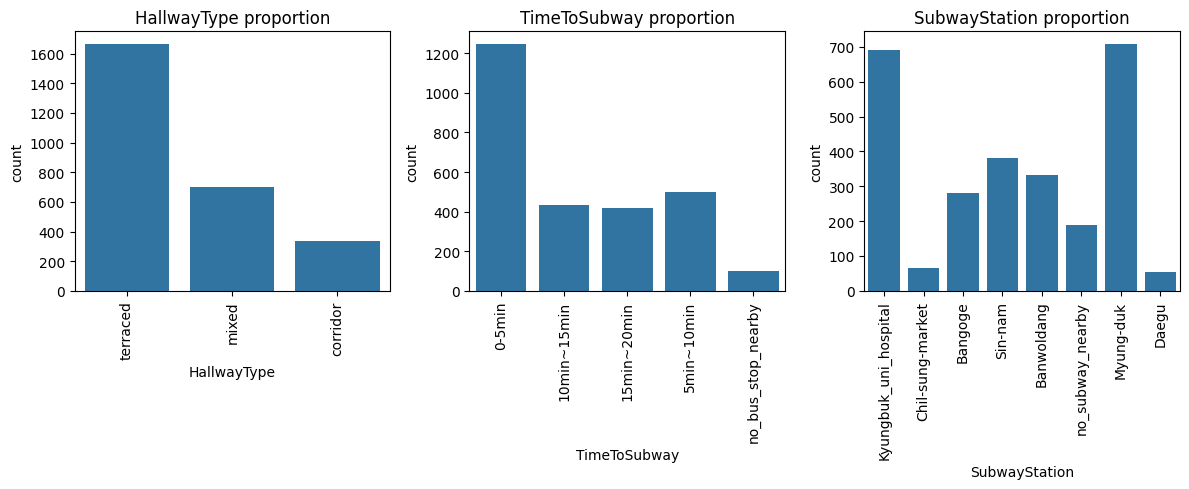

In [49]:
plt.figure(figsize=(12, 5))
for i, var in enumerate(cat_vars):
    plt.subplot(1, 3, i+1)
    plt.title(f"{var} proportion")
    sns.countplot(data=df, x=var, y="SalePrice")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.savefig(file_to_save + "category_proportion.png")
plt.show()

## Multivariate

### Numerical Variables

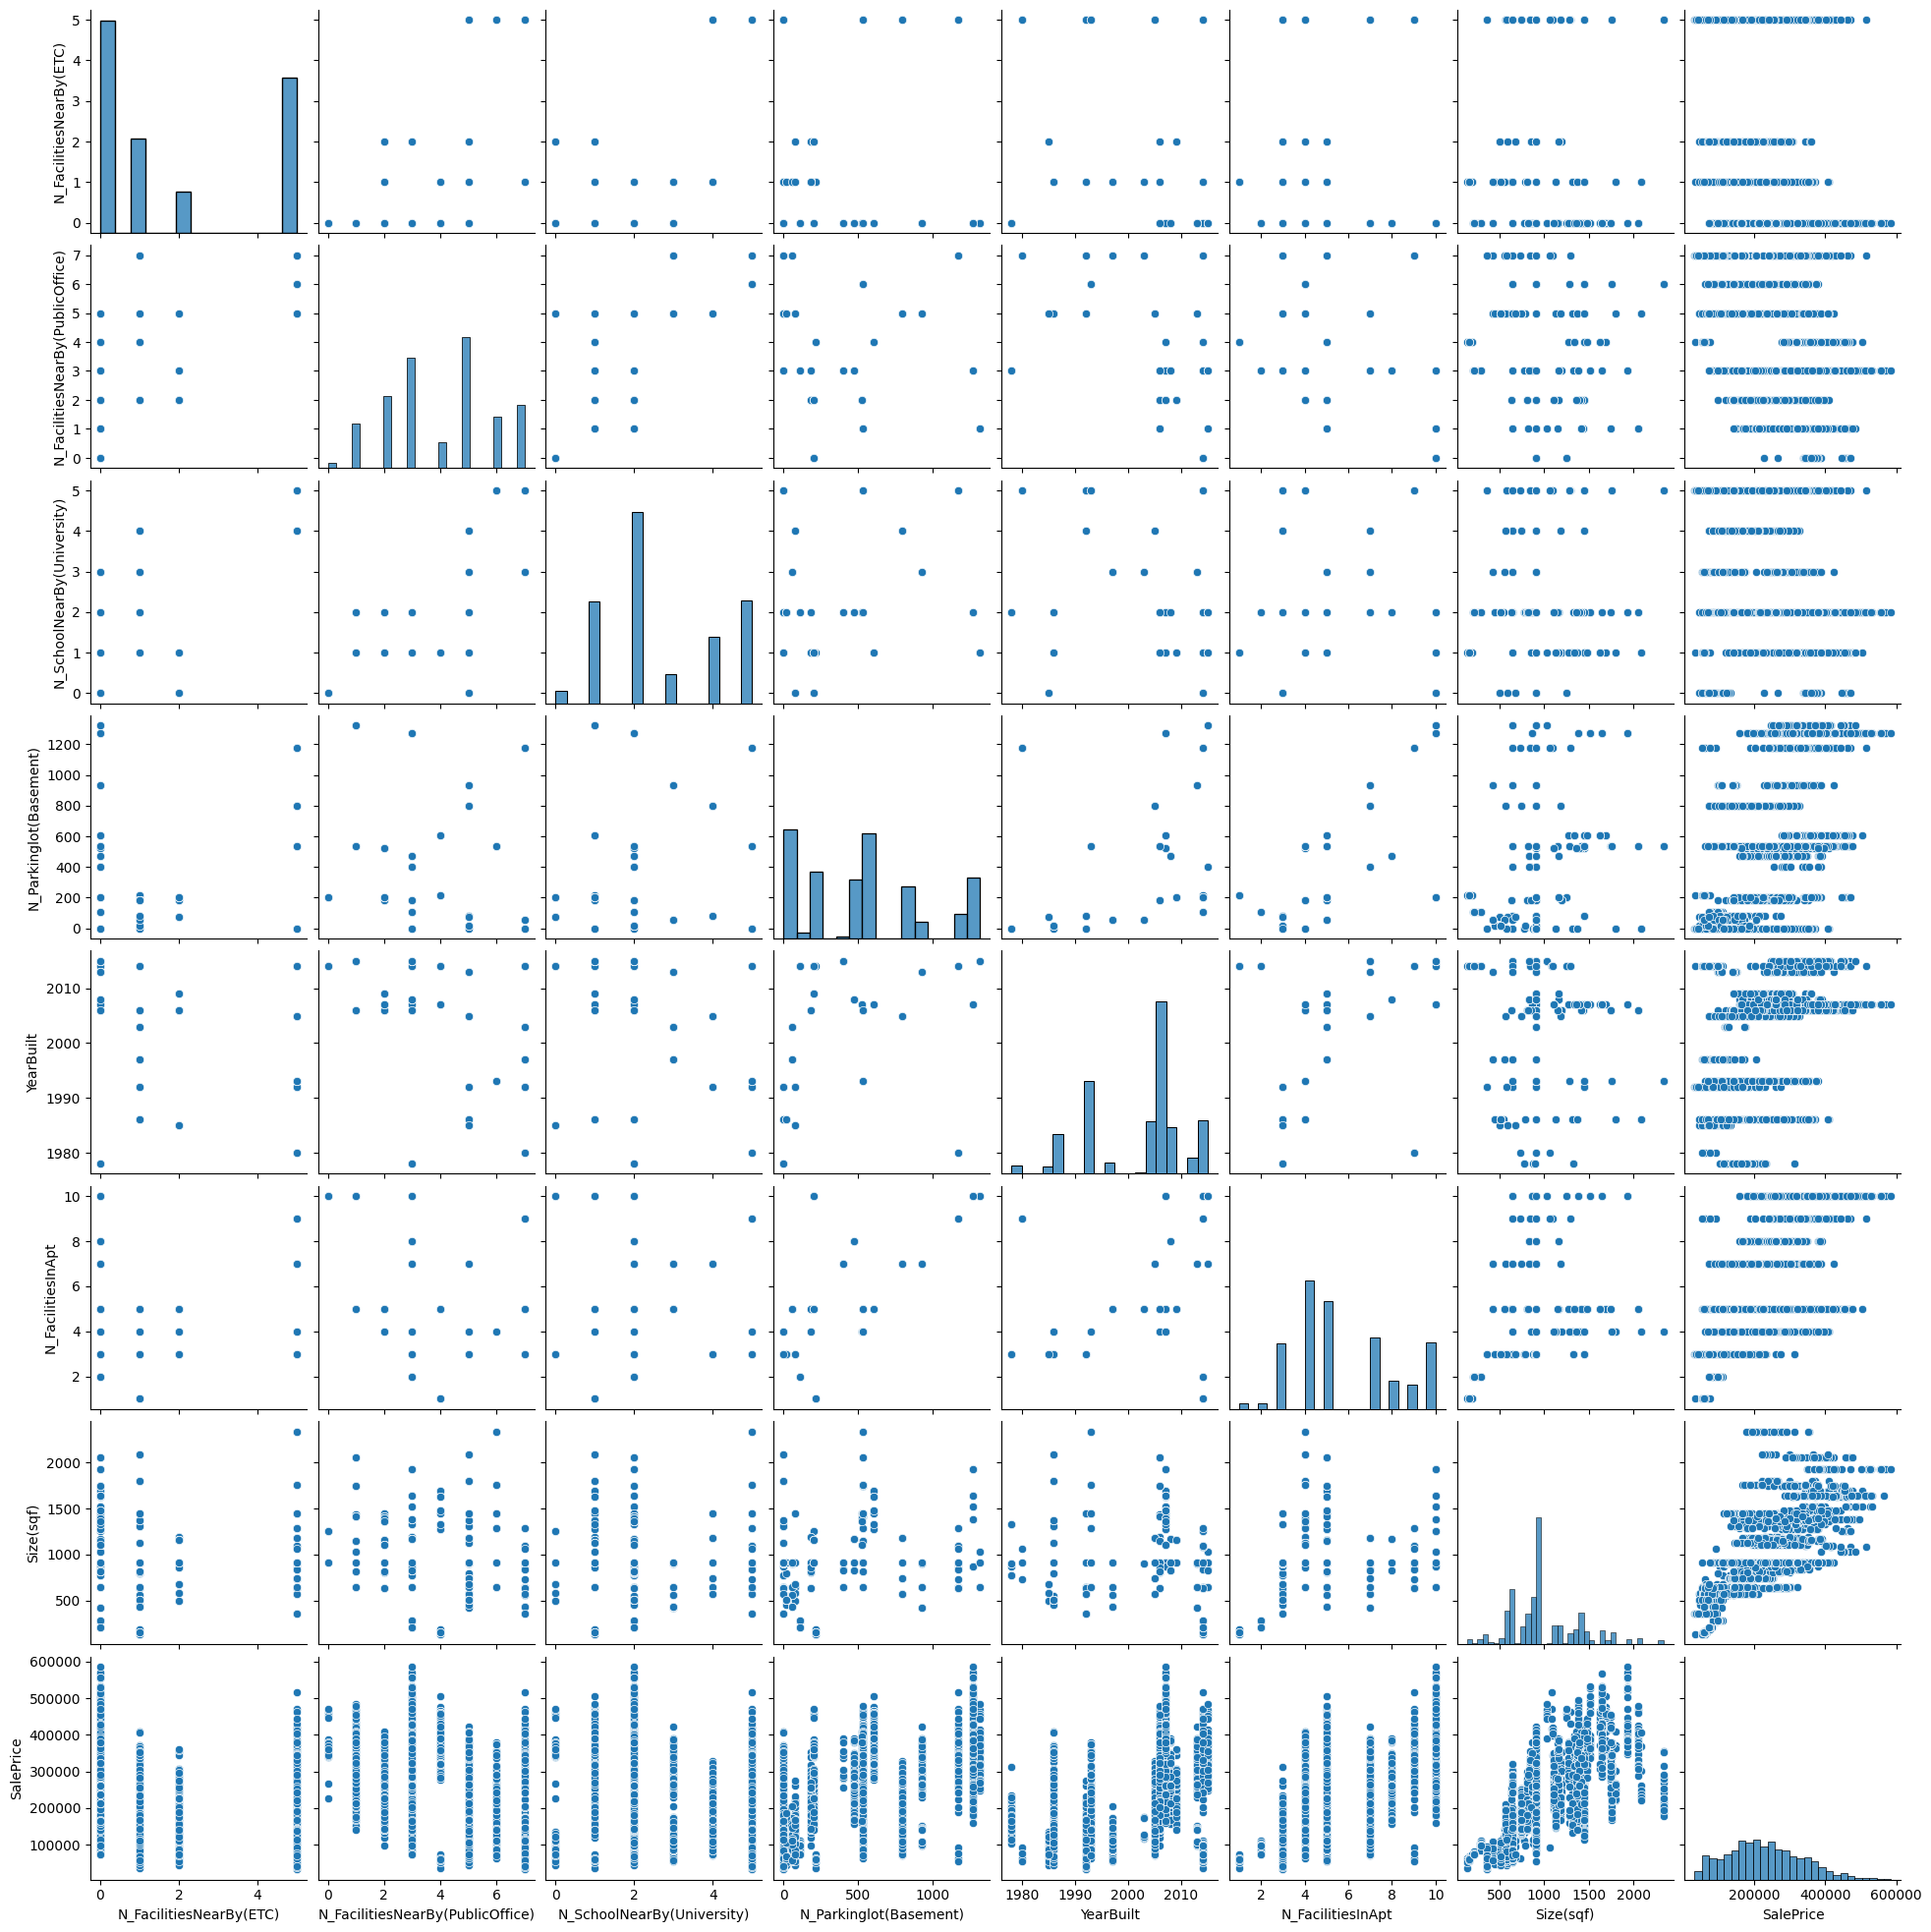

In [60]:
sns.pairplot(data=df[num_vars])

### Categorical Variables

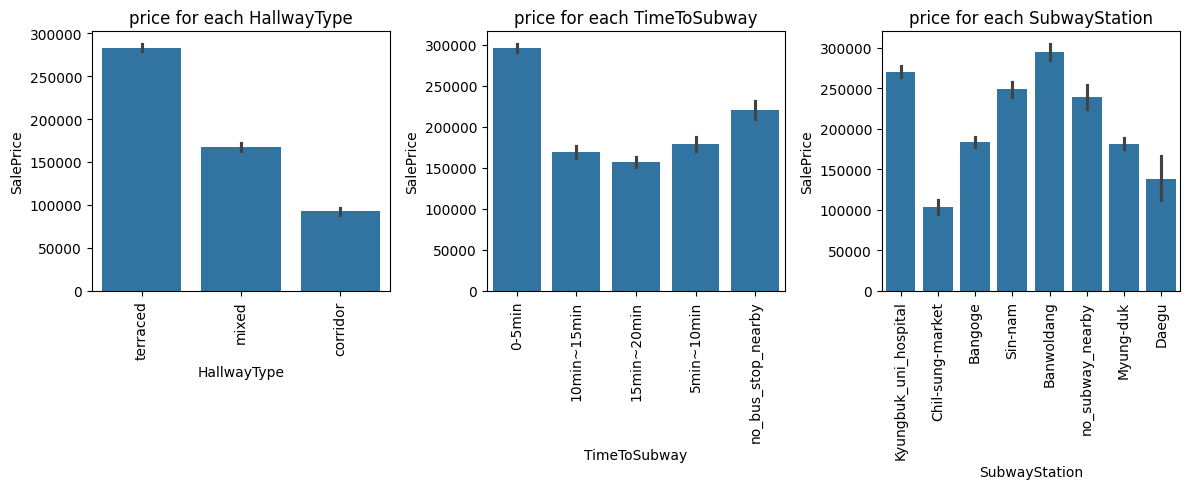

In [47]:
plt.figure(figsize=(12, 5))
for i, var in enumerate(cat_vars):
    plt.subplot(1, 3, i+1)
    plt.title(f"price for each {var}")
    sns.barplot(data=df, x=var, y="SalePrice")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.savefig(file_to_save + "target_x_category.png")
plt.show()

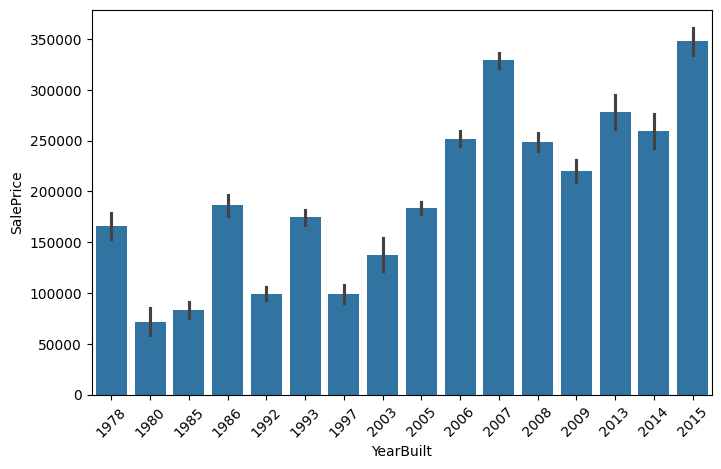

In [ ]:
# Hubungan antara YearBuilt dengan SalesPrice

plt.figure(figsize = (8, 5))
sns.barplot(data = df, x = "YearBuilt", y = "SalePrice")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# Binning
df["YearBuilt"] = pd.cut(df["YearBuilt"], 5).astype("str")

**Outlier Checking**

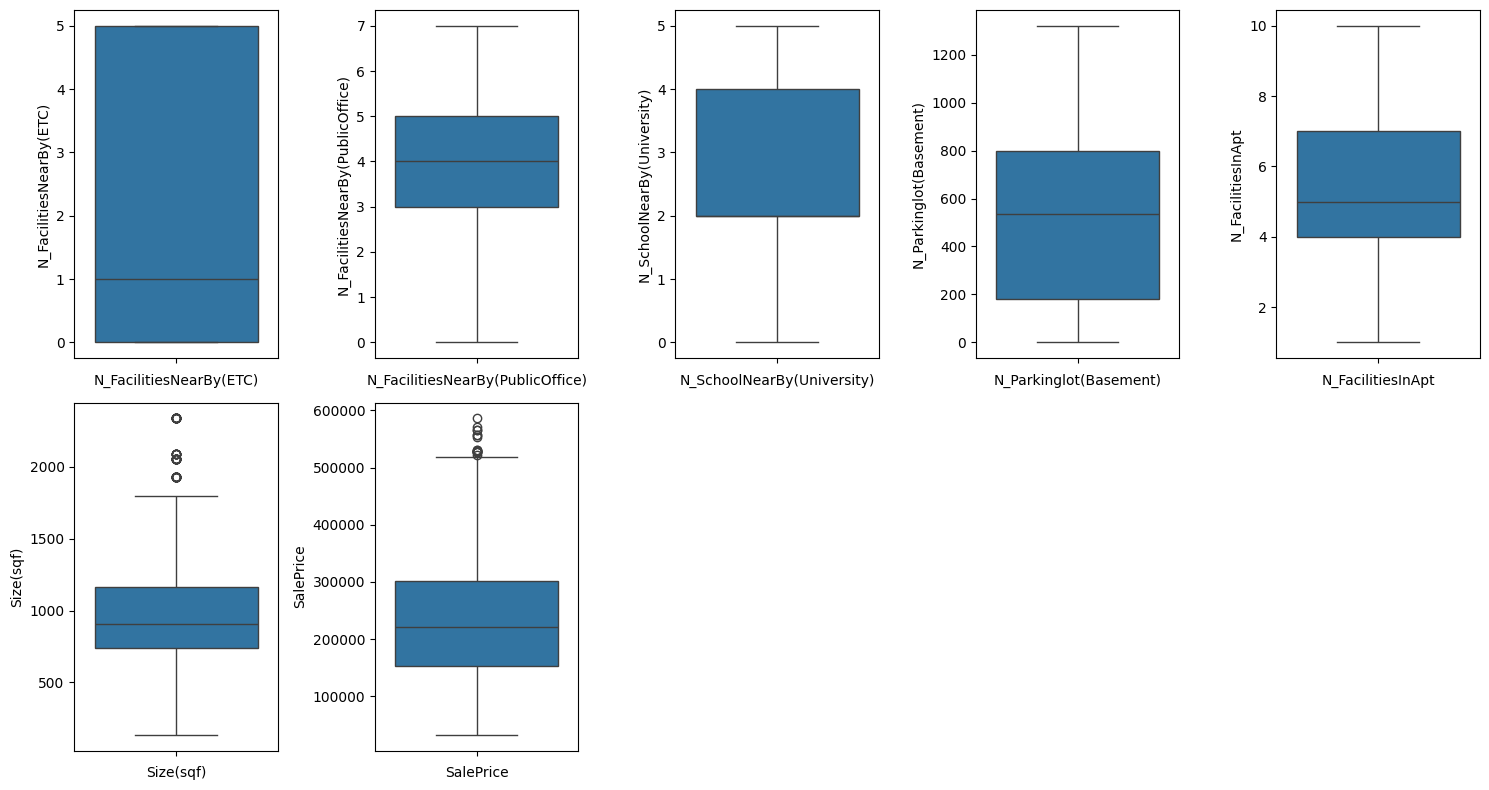

In [ ]:
# Boxplot

i = 1

plt.figure(figsize=(15, 8))
for col in num_col:
    ax = plt.subplot(2, 5, i)
    sns.boxplot(y = df[col], ax = ax, orient = "v")
    plt.xlabel(col)
    plt.tight_layout()

    i += 1

Terlihat bahwa kolom target `SalePrice` dan kolom `Size(sqf)` memiliki outlier. kita perlu untuk menghapus outlier pada kedua kolom ini supaya model yang kita punya bisa lebih _robust_ atau stabil, karena tidak ada nilai yang sifatnya beda sendiri dan sedikit pada model.

In [ ]:
# remove outlier

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range

    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    
    return df_out

In [ ]:
df = remove_outlier(df, "SalePrice")
df = remove_outlier(df, "Size(sqf)")

**Corelasi**

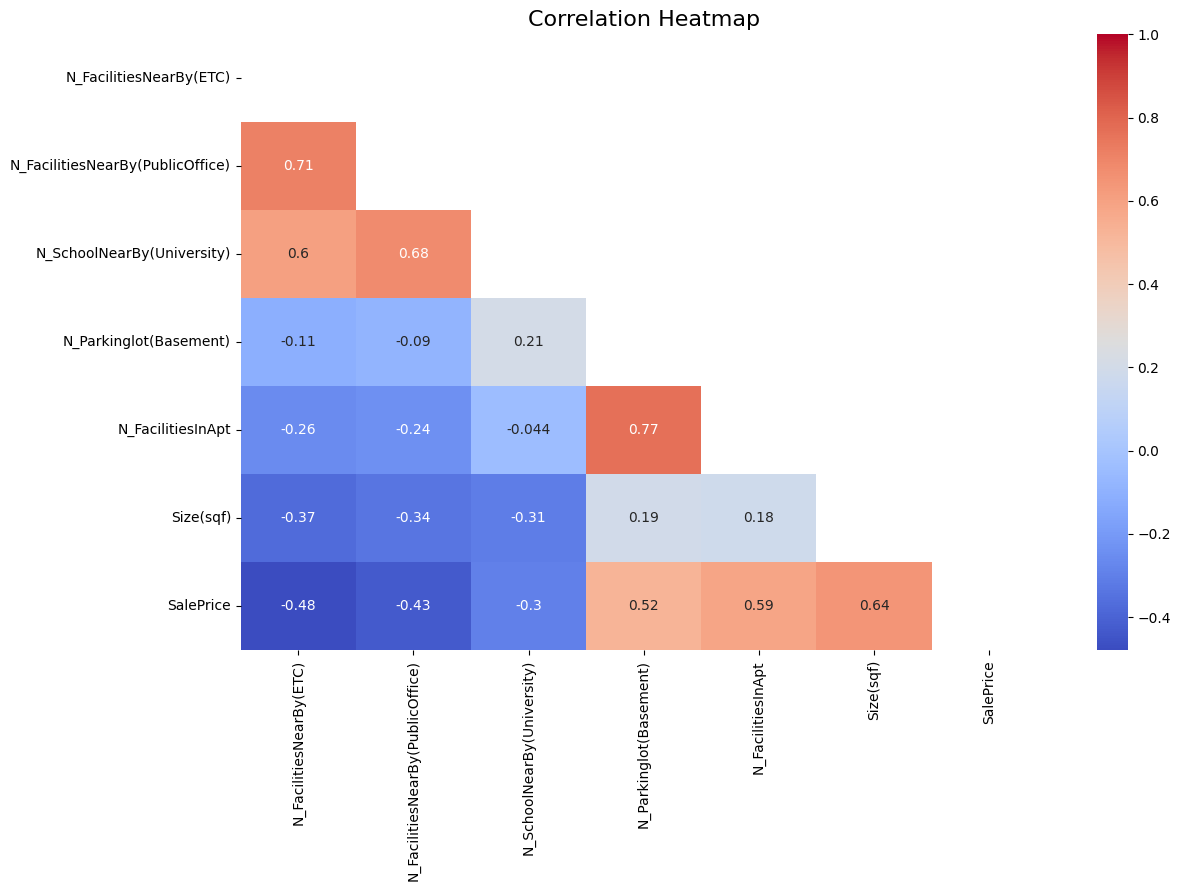

In [ ]:
mask = np.zeros_like(df[num_col].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (13, 8))
plt.title("Correlation Heatmap", size = 16)
sns.heatmap(df[num_col].corr(method = "spearman"), cmap = "coolwarm", annot = True, mask = mask, vmax = 1)
plt.show()

Beberapa variabel terlihat saling berkorelasi tinggi. Ada indikasi akan ada masalah multikolinearitas.

# Modelling

## Preprocessing Scenario

In [ ]:
df.columns

Index(['HallwayType', 'TimeToSubway', 'SubwayStation',
       'N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
       'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
       'N_FacilitiesInApt', 'Size(sqf)', 'SalePrice'],
      dtype='object')

In [ ]:
# scaling data
scaler = StandardScaler()
scaling_col = [
    'N_FacilitiesNearBy(ETC)',
    'N_FacilitiesNearBy(PublicOffice)',
    'N_SchoolNearBy(University)',
    'N_Parkinglot(Basement)',
    'N_FacilitiesInApt',
    'Size(sqf)'
]

# One Hot Encoding
onehot = OneHotEncoder(drop = "first")

# Binary Encoding
binary = ce.BinaryEncoder()

# Transformer
transformer = ColumnTransformer([
    ("scaling", scaler, scaling_col),
    ("onehot", onehot, ["HallwayType", "TimeToSubway"]),
    ("binary", binary, ["SubwayStation", "YearBuilt"])
])

## Data Splitting

Nilai kolom target `SalePrice` bernilai puluhan ribu akan menyebabkan nilai error cenderung besar-besar. Sehingga kita akan transformasi nilainya menggunakan skala logaritmik dengan basis 10. Transformasi ini hanya mengecilkan nilai tanpa merubah maknanya karena transformasi ini bisa direverse untuk mendapatkan nilai yang sesungguhnya.

In [ ]:
X = df.drop(columns = ["SalePrice"])
# y = df["SalePrice"]
y = np.log10(df['SalePrice'])

In [ ]:
# Validasi
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size = 540,
    random_state = 2022
)

In [ ]:
X_trainval_prep = transformer.fit_transform(X_trainval)
X_test_prep = transformer.fit_transform(X_test)

In [ ]:
col = (
    transformer.transformers_[0][2] 
    + transformer.transformers_[1][1].get_feature_names_out().tolist()
    + transformer.transformers_[2][1].get_feature_names() 
)

ValueError: operands could not be broadcast together with shapes (12,) (7,) 

In [ ]:
pd.DataFrame(X_trainval_prep, columns = col)

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),N_FacilitiesInApt,Size(sqf),HallwayType_mixed,HallwayType_terraced,TimeToSubway_10min~15min,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_0,SubwayStation_1,SubwayStation_2,SubwayStation_3,YearBuilt_0,YearBuilt_1,YearBuilt_2
0,1.449311,1.565260,1.545527,-1.256457,-1.135601,-1.081829,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.048911,0.502074,-1.784463,-1.074589,-1.135601,-0.787666,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.884689,-0.561112,-0.452467,1.782663,1.809971,1.692127,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,-0.884689,-0.561112,-0.452467,1.782663,1.809971,2.056888,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,1.449311,0.502074,0.879529,0.653163,0.547583,-0.087559,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,-0.417889,0.502074,-1.118465,-1.256457,-0.714805,-0.087559,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2067,-0.884689,0.502074,0.213531,0.969040,0.547583,-0.099325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2068,-0.417889,0.502074,-1.118465,-1.256457,-0.714805,0.550775,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2069,-0.884689,-0.561112,-0.452467,-0.299254,0.547583,-0.087559,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Benchmark

Model benchmark disini adalah model yang menggunakan parameter default. Kita akan menguji semua opsi model yang kita punya dengan parameter-parameter defaultnya. Model yang memiliki performa paling bagus dengan parameter default, punya kemungkinan untuk lebih bagus lagi ketika kita optimasi dengan hyperparameter tuning. Jadi benchmark model merupakan langkah awal yang kita lakukan dalam pemilihan model.

In [ ]:
# Model Benchmark (menggunakan parameter default)

lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state = 2022)
rf = RandomForestRegressor(random_state = 2022)
xgb = XGBRegressor(random_state = 2022)

Disini kita menggunakan root mean square error sebagai alat ukur untuk mengetahui model dengan performa terbaik. Semakin bagus modelnya, semakin nilai RMSE nya mendekati nol.

In [ ]:
def model_evaluation(model, metric):
  skfold = KFold(n_splits = 5, shuffle = True, random_state = 2022)
  model_cv = cross_val_score(model, X_trainval_prep, y_trainval, cv = skfold, scoring = metric)

  print("hasil cross validasi : ", model_cv)
  print("rata-rata cross validasi : ", model_cv.mean())
  print("standar deviasi cross validasi : ", model_cv.std())

In [ ]:
model_evaluation(lr, "neg_root_mean_squared_error")

hasil cross validasi :  [-0.10758522 -0.10878613 -0.10944104 -0.10534321 -0.11110114]
rata-rata cross validasi :  -0.10845134629468278
standar deviasi cross validasi :  0.0019247657498843076


In [ ]:
model_evaluation(lasso, "neg_root_mean_squared_error")

hasil cross validasi :  [-0.23406821 -0.23106447 -0.23674105 -0.24342946 -0.22840736]
rata-rata cross validasi :  -0.23474211027622577
standar deviasi cross validasi :  0.005168638282366505


In [ ]:
model_evaluation(ridge, "neg_root_mean_squared_error")

hasil cross validasi :  [-0.1077751  -0.108645   -0.10955937 -0.10538421 -0.11074858]
rata-rata cross validasi :  -0.10842245063838954
standar deviasi cross validasi :  0.0018112404772745632


In [ ]:
model_evaluation(knn, "neg_root_mean_squared_error")

hasil cross validasi :  [-0.10424373 -0.10570196 -0.1054501  -0.1017784  -0.10180414]
rata-rata cross validasi :  -0.10379566568587198
standar deviasi cross validasi :  0.0017092340592474715


In [ ]:
model_evaluation(tree, "neg_root_mean_squared_error")

hasil cross validasi :  [-0.09921955 -0.09967179 -0.10124679 -0.0967927  -0.10069197]
rata-rata cross validasi :  -0.09952456169735553
standar deviasi cross validasi :  0.0015431573352422078


In [ ]:
model_evaluation(rf, "neg_root_mean_squared_error")

hasil cross validasi :  [-0.09924231 -0.10033072 -0.10111485 -0.09584538 -0.10070773]
rata-rata cross validasi :  -0.09944820113556341
standar deviasi cross validasi :  0.0019060791114920042


In [ ]:
model_evaluation(xgb, "neg_root_mean_squared_error")

[15:23:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
hasil cross validasi :  [-0.09863063 -0.0990319  -0.0992501  -0.09504534 -0.09943133]
rata-rata cross validasi :  -0.09827786040742277
standar deviasi cross validasi :  0.0016381649679361933


Berdasarkan nilai dari RMSE, maka model XGBoost memiliki nilai terbaik (Karena paling mendekati nol) walaupun perbedaan nilai rata-rata RMSE nya untuk model tree dan random forest terpantau sangat kecil. Selanjutnya kita akan melakukan prediksi dengan menggunakan model benchmark XGBoost, RandomForest, dan DecisionTree karena ketiga model ini sama-sama memiliki potensi.

## Benchmark Model in Test Set

Kita akan menggunakan MAE dan MAPE juga sebagain evaluation metrics supaya lebih banyak nilai error yang kita bandingkan.

In [ ]:
tree = DecisionTreeRegressor(random_state = 2022)
rf = RandomForestRegressor(random_state = 2022)
xgb = XGBRegressor(random_state = 2022)

models = [tree, rf, xgb]

rmse = []
mae = []
mape = []

for model in models:
  model.fit(X_trainval_prep, y_trainval)
  y_pred = model.predict(X_test_prep)

  rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
  mae.append(mean_absolute_error(y_test, y_pred))
  mape.append(mean_absolute_percentage_error(y_test, y_pred))

score = pd.DataFrame({
    "RMSE" : rmse,
    "MAE" : mae,
    "MAPE" : mape
}, index = ["Tree", "RandomForest", "XGBoost"])

[15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
score

,RMSE,MAE,MAPE
Tree,0.114022,0.085184,0.016266
RandomForest,0.110975,0.084127,0.016050
XGBoost,0.108670,0.084227,0.016039


Terlihat bahwa ketika dilakukan prediksi pada test set, performa RandomForest secara akumulatif lebih baik meskipun perbedaan nilainya cukup kecil. Hal ini berlaku untuk semua metrics (RMSE, MAE, MAPE)

## Hyperparameter Tuning

Karena RandomForest memiliki performa yang sedikit lebih baik, maka selanjutnya kita akan melakukan hyperparameter tuning menggunakan model ini sebagai model akhir. 

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_trainval_prep,
    y_trainval,
    test_size = 540,
    random_state = 2022
)

In [ ]:
# jumlah pohon pada random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# jumlah feature untuk setiap split
max_features = ['auto', 'sqrt']

# kedalaman pohon
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum sample split
min_samples_split = [2, 5, 10, 15, 100]

# Minimum sample leaf
min_samples_leaf = [1, 2, 5, 10]

# Hyperparam
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [ ]:
crossval = KFold(n_splits = 5, shuffle = True, random_state = 2022)

random_rf = RandomizedSearchCV(
    RandomForestRegressor(), 
    param_distributions = random_grid, 
    cv = crossval, 
    n_iter = 50,
    n_jobs = -1
)

In [ ]:
# Fitting Data untuk mencari score terbaik
random_rf.fit(x_train, y_train)

# Cek skor dan params terbaik
print('Random Forest')
print('Best_score:', random_rf.best_score_)
print('Best_params:', random_rf.best_params_)

Random Forest
Best_score: 0.8167062035611664
Best_params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}


In [ ]:
y_pred_val = random_rf.predict(x_val)

print('tabel error randomforest : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_val))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_val))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_val)))

tabel error randomforest : 
Mean Absolute Error      :  0.2429798817549579
Mean Squared  Error      :  0.09417924712190917
Root Mean Squared  Error :  0.3068863749368961


**Prediction with Choosen Model**

Melakukan prediksi pada test set dengan parameter-parameter yang sudah dituning.

In [ ]:
# model dengan hyperparameter terbaik
rf_tuned = random_rf.best_estimator_

# fiting model
rf_tuned.fit(x_train, y_train)

# Predict
y_pred_tuned = rf_tuned.predict(X_test_prep)

print('tabel error randomforest tuned : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_tuned))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_tuned))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_tuned)))

tabel error randomforest tuned : 
Mean Absolute Error      :  0.08568088449754109
Mean Squared  Error      :  0.012040840209825415
Root Mean Squared  Error :  0.10973076236783108


**Performance Comparison**

In [ ]:
# sebelum tuning
rf.fit(x_train, y_train)
y_pred_before = rf.predict(X_test_prep)

print('tabel error randomforest sebelum tuning : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_before))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_before))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_before)))
print('Mean Absolute Percentage Error : ', mean_absolute_percentage_error(y_test, y_pred_before))

print()

print('tabel error randomforest sesudah tuning : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_tuned))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_tuned))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print('Mean Absolute Percentage Error : ', mean_absolute_percentage_error(y_test, y_pred_tuned))

tabel error randomforest sebelum tuning : 
Mean Absolute Error      :  0.08559355205776496
Mean Squared  Error      :  0.013008217530858342
Root Mean Squared  Error :  0.11405357307361459
Mean Absolute Percentage Error :  0.016300784313787474

tabel error randomforest sesudah tuning : 
Mean Absolute Error      :  0.08568088449754109
Mean Squared  Error      :  0.012040840209825415
Root Mean Squared  Error :  0.10973076236783108
Mean Absolute Percentage Error :  0.016350505523566823


Text(0, 0.5, 'Predicted Price')

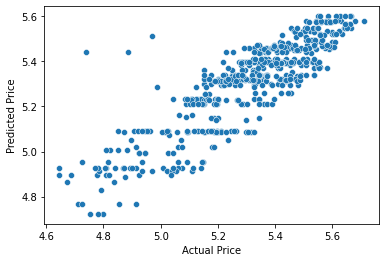

In [ ]:
sns.scatterplot(x = y_test, y = y_pred_tuned)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

**Feature Importance**

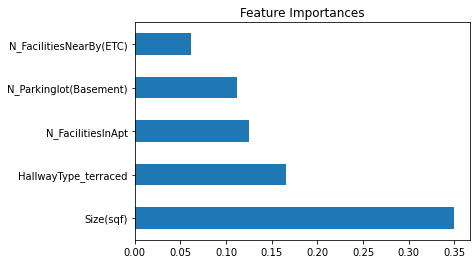

In [ ]:
# Plot feature importances
feature_imp = pd.Series(rf_tuned.feature_importances_, col).sort_values(ascending = False).head()
feature_imp.plot(kind='barh', title='Feature Importances');

# Conclusion

Berdasarkan permodelan yang sudah dilakukan, ukuran luas apartement dan tipe lorong nya menjadi fitur yang paling berpengaruh dalam penentuan harga apartement.

Jika ditinjau dari besar nya MAPE(Mean Absolute Percentage Error) yaitu ~1.6%, kita dapat menyimpulkan bahwa model yang kita buat ketika memprediksi harga untuk data baru dengan catatan rentang nilainya sama dengan nilai data training, maka perkiraan rata-rata akan meleset kurang lebih sebesar 1.6% dari harga seharusnya.